In [29]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
pd.options.display.float_format = '{:.4f}'.format

ปรับรูปแบบวันที่

In [30]:
def date_format_year_month(df, year_col='Year', month_col='Month'):
    # สร้างคอลัมน์วันที่ใหม่แบบรวมปีและเดือน
    df = df.copy()
    df['year_month'] = pd.to_datetime(df[year_col].astype(str) + '-' + df[month_col].astype(str).str.zfill(2), format='%Y-%m').dt.strftime('%Y-%m')
    df = df.drop(columns=[year_col, month_col], errors='ignore')

    cols = ['year_month'] + [col for col in df.columns if col != 'year_month']
    df = df[cols]

    return df

def date_format_day(df, date_col='Date'):
    df = df.copy()
    df['year_month'] = pd.to_datetime(df[date_col], format='%Y-%m').dt.strftime('%Y-%m')
    df = df.drop(columns=[date_col], errors='ignore')

    cols = ['year_month'] + [col for col in df.columns if col != 'year_month']
    df = df[cols]

    return df

Import Data

In [31]:
def import_data():
    file_path = 'DS - 4001 Factors.xlsx'
    
    def load_and_format(sheet_name, date_col_config, rename_dict, month_col='Month'):
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        if date_col_config['type'] == 'year_month':
            df = date_format_year_month(df, year_col='Year', month_col=month_col)
        else:  # day
            df = date_format_day(df, date_col=date_col_config['col_name'])
        
        df = df.rename(columns=rename_dict)
        return df
    
    data_dict = {
        'df_production': load_and_format('Thai Production', 
                                         {'type': 'year_month'}, 
                                         {'Production': 'thai_production'}),
        'df_consumption': load_and_format('Consumption', 
                                          {'type': 'year_month'}, 
                                          {'Consumption': 'domestic_consumption'}),
        'df_import': load_and_format('Import', 
                                     {'type': 'year_month'}, 
                                     {'Import qty (Mt)': 'import_volume'}),
        'df_export': load_and_format('Export', 
                                     {'type': 'year_month'}, 
                                     {'Export qty (Mt)': 'export_volume'}),
        'df_stock': load_and_format('Stock', 
                                    {'type': 'year_month'}, 
                                    {'Stock': 'stock'}),
        'df_exchange': load_and_format('Currency Exchange Rate', 
                                       {'type': 'year_month'}, 
                                       {'Buying Rate (US Dollar)': 'exchange_rate_usd'}),
        'df_china_pmi': load_and_format('China PMI', 
                                        {'type': 'year_month'}, 
                                        {'PMI': 'china_pmi'}, 
                                        month_col='Month'),
        'df_world_price': load_and_format('World Prices', 
                                          {'type': 'day', 'col_name': 'Date'}, 
                                          {'Prices': 'world_price'}),
        'df_thai_price': load_and_format('Thai Prices', 
                                         {'type': 'year_month'}, 
                                         {'Prices': 'thai_price'}),
    }
    
    df_oil = pd.read_excel(file_path, sheet_name='Oil Prices', usecols=['Date', 'Lastest Prices'])
    df_oil = date_format_day(df_oil, date_col='Date')
    df_oil = df_oil.rename(columns={'Lastest Prices': 'oil_price'})
    data_dict['df_oil'] = df_oil

    return data_dict

import_data()


{'df_production':     year_month  thai_production
 0      2007-01           328940
 1      2007-02           267868
 2      2007-03           246813
 3      2007-04           165458
 4      2007-05           172153
 ..         ...              ...
 217    2025-02           578922
 218    2025-03           413728
 219    2025-04           267722
 220    2025-05           416062
 221    2025-06           339807
 
 [222 rows x 2 columns],
 'df_consumption':     year_month  domestic_consumption
 0      2007-01                 30652
 1      2007-02                 26790
 2      2007-03                 31717
 3      2007-04                 27788
 4      2007-05                 32905
 ..         ...                   ...
 217    2025-02                109368
 218    2025-03                 95398
 219    2025-04                 69306
 220    2025-05                 90856
 221    2025-06                 86959
 
 [222 rows x 2 columns],
 'df_import':     year_month  import_volume
 0      2007-01

Merge Data

In [32]:
def merge_data(df_dict):
    time_range = pd.date_range(start='2007-01', end='2025-06', freq='MS')
    df_merged = pd.DataFrame({'year_month': time_range.strftime('%Y-%m')})
    
    for key, df in df_dict.items():
        if key != 'df_production':
            df_merged = pd.merge(df_merged, df, on='year_month', how='left')
    
    df_merged = df_merged.sort_values(by='year_month').reset_index(drop=True)
    return df_merged

merge_data(import_data())


,year_month,domestic_consumption,import_volume,export_volume,stock,exchange_rate_usd,china_pmi,world_price,thai_price,oil_price
0,2007-01,30652,55,267567.0000,280671.0000,36.1800,54.8000,94.2393,65.1200,58.1400
1,2007-02,26790,44,237979.0000,NaN,35.7500,55.1000,103.3625,72.9100,61.7900
2,2007-03,31717,119,230410.0000,217339.0000,35.0600,53.1000,101.7234,69.6200,65.8700
3,2007-04,27788,184,180185.0000,178575.0000,34.8700,56.1000,105.2449,72.8400,65.7100
4,2007-05,32905,91,178103.0000,209215.0000,34.6200,58.6000,107.4421,NaN,64.0100
...,...,...,...,...,...,...,...,...,...,...
217,2025-02,109368,63,369222.0000,1050152.0000,33.9385,50.2000,110.2390,67.9100,69.7600
218,2025-03,95398,111,369396.0000,999197.0000,33.9768,50.5000,108.6269,66.5600,71.4800
219,2025-04,69306,73,317716.0000,879970.0000,33.9148,49.0000,98.8647,59.6900,58.2100
220,2025-05,90856,123,360478.0000,844821.0000,33.1076,49.5000,101.0811,64.0500,60.7900


ปรับหน่วยข้อมูล

In [33]:
# ton -> kg
def ton_to_kg(df):
    df = df.copy()
    volume_cols = ['thai_production', 'domestic_consumption', 'import_volume', 'export_volume', 'stock']
    for col in volume_cols:
        if col in df.columns:
            df[col] = df[col] * 1000
    return df

# usd -> thb
def usd_to_thb(df):
    df = df.copy()
    if 'oil_price' in df.columns and 'exchange_rate_usd' in df.columns:
        df['oil_price_thb'] = df['oil_price'] * df['exchange_rate_usd']
        df = df.drop(columns=['oil_price'], errors='ignore')
    return df

# us cents per pound -> thb per kg
def convert_world_price_unit(df):
    df = df.copy()
    if 'world_price' in df.columns and 'exchange_rate_usd' in df.columns:
        usd_per_lb = df['world_price'] / 100
        usd_per_kg = usd_per_lb * 2.20462

        df['world_price_thb_kg'] = usd_per_kg * df['exchange_rate_usd']
        df = df.drop(columns=['world_price'], errors='ignore')
    
    return df

merged_data = merge_data(import_data())
converted_data = ton_to_kg(merged_data)
converted_data = usd_to_thb(converted_data)
converted_data = convert_world_price_unit(converted_data)

converted_data

,year_month,domestic_consumption,import_volume,export_volume,stock,exchange_rate_usd,china_pmi,thai_price,oil_price_thb,world_price_thb_kg
0,2007-01,30652000,55000,267567000.0000,280671000.0000,36.1800,54.8000,65.1200,2103.5052,75.1683
1,2007-02,26790000,44000,237979000.0000,NaN,35.7500,55.1000,72.9100,2208.9925,81.4653
2,2007-03,31717000,119000,230410000.0000,217339000.0000,35.0600,53.1000,69.6200,2309.4022,78.6261
3,2007-04,27788000,184000,180185000.0000,178575000.0000,34.8700,56.1000,72.8400,2291.3077,80.9071
4,2007-05,32905000,91000,178103000.0000,209215000.0000,34.6200,58.6000,NaN,2216.0262,82.0040
...,...,...,...,...,...,...,...,...,...,...
217,2025-02,109368000,63000,369222000.0000,1050152000.0000,33.9385,50.2000,67.9100,2367.5498,82.4825
218,2025-03,95398000,111000,369396000.0000,999197000.0000,33.9768,50.5000,66.5600,2428.6617,81.3680
219,2025-04,69306000,73000,317716000.0000,879970000.0000,33.9148,49.0000,59.6900,1974.1805,73.9204
220,2025-05,90856000,123000,360478000.0000,844821000.0000,33.1076,49.5000,64.0500,2012.6110,73.7788


Missing Value

In [34]:
def handle_missing_values(df):
    df = df.copy()
    
    # show missing values
    print('Before: Missing Values')
    sum_missing = df.isnull().sum()
    print(sum_missing)
    rows_with_missing = df[df.isnull().any(axis=1)]
    
    if len(rows_with_missing) > 0:
        print(rows_with_missing.head(10).to_string(index=False))
    else:
        print("No rows with missing values")
    print('\n')
    
    # handle missing values
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        # ใช้ linear interpolation พราะข้อมูลที่หายไปมีแนวโน้มเป็นเชิงเส้น
        if missing_count > 0:
            df[col] = df[col].interpolate(method='linear')
            print(f"{col} interpolated with linear method")
    
    print('\nAfter: Missing Values')
    sum_missing_after = df.isnull().sum()
    print(sum_missing_after)
    
    return df

handle_missing_values(converted_data)

Before: Missing Values
year_month              0
domestic_consumption    0
import_volume           0
export_volume           1
stock                   1
exchange_rate_usd       0
china_pmi               0
thai_price              1
oil_price_thb           0
world_price_thb_kg      0
dtype: int64
year_month  domestic_consumption  import_volume  export_volume          stock  exchange_rate_usd  china_pmi  thai_price  oil_price_thb  world_price_thb_kg
   2007-02              26790000          44000 237979000.0000            NaN            35.7500    55.1000     72.9100      2208.9925             81.4653
   2007-05              32905000          91000 178103000.0000 209215000.0000            34.6200    58.6000         NaN      2216.0262             82.0040
   2008-04              30104000         637000            NaN 236850000.0000            31.5900    58.4000     81.1000      3584.2014             89.5577


export_volume interpolated with linear method
stock interpolated with linear metho

,year_month,domestic_consumption,import_volume,export_volume,stock,exchange_rate_usd,china_pmi,thai_price,oil_price_thb,world_price_thb_kg
0,2007-01,30652000,55000,267567000.0000,280671000.0000,36.1800,54.8000,65.1200,2103.5052,75.1683
1,2007-02,26790000,44000,237979000.0000,249005000.0000,35.7500,55.1000,72.9100,2208.9925,81.4653
2,2007-03,31717000,119000,230410000.0000,217339000.0000,35.0600,53.1000,69.6200,2309.4022,78.6261
3,2007-04,27788000,184000,180185000.0000,178575000.0000,34.8700,56.1000,72.8400,2291.3077,80.9071
4,2007-05,32905000,91000,178103000.0000,209215000.0000,34.6200,58.6000,71.4700,2216.0262,82.0040
...,...,...,...,...,...,...,...,...,...,...
217,2025-02,109368000,63000,369222000.0000,1050152000.0000,33.9385,50.2000,67.9100,2367.5498,82.4825
218,2025-03,95398000,111000,369396000.0000,999197000.0000,33.9768,50.5000,66.5600,2428.6617,81.3680
219,2025-04,69306000,73000,317716000.0000,879970000.0000,33.9148,49.0000,59.6900,1974.1805,73.9204
220,2025-05,90856000,123000,360478000.0000,844821000.0000,33.1076,49.5000,64.0500,2012.6110,73.7788


In [35]:
def time_features(df):
    df = df.copy()
    df['month'] = pd.to_datetime(df['year_month']).dt.month
    df['quarter'] = pd.to_datetime(df['year_month']).dt.quarter
    df['year'] = pd.to_datetime(df['year_month']).dt.year
    
    # Seasonal
    df['is_season'] = df['month'].apply(lambda x: 1 if 5 <= x <= 6 else 0)
    
    return df

In [36]:
def lag_features(df):
    df = df.copy()
    
    # Lag features สำหรับตัวแปรที่มีผลต่อราคา
    lag_vars = ['thai_price', 'world_price_thb_kg', 'oil_price_thb',
                'china_pmi', 'thai_production', 'stock']
    lag_periods = [1, 3, 6, 12]
    
    for var in lag_vars:
        if var in df.columns:
            for lag in lag_periods:
                df[f'{var}_lag{lag}'] = df[var].shift(lag)
    
    return df

In [37]:
def rolling_features(df):
    df = df.copy()
    
    roll_vars = ['thai_price', 'world_price_thb_kg', 'oil_price_thb', 'china_pmi']
    windows = [1, 3, 6, 12]
    
    for var in roll_vars:
        if var in df.columns:
            for window in windows:
                # Moving Average
                df[f'{var}_ma{window}'] = df[var].rolling(window=window).mean()
                # Rolling Std
                df[f'{var}_std{window}'] = df[var].rolling(window=window).std()
    
    return df

In [38]:
def rate_of_change(df):
    df = df.copy()
    
    change_vars = ['thai_price', 'world_price_thb_kg', 'oil_price_thb', 
                   'exchange_rate_usd', 'thai_production']
    periods = [1, 3,6, 12]
    
    for var in change_vars:
        if var in df.columns:
            for period in periods:
                df[f'{var}_pct{period}'] = df[var].pct_change(periods=period) * 100
    
    return df

In [39]:
def fill_feature_eng_nulls(df):
    df = df.copy()
    
    # Lag features - ใช้ forward fill
    lag_cols = [col for col in df.columns if '_lag' in col]
    for col in lag_cols:
        df[col] = df[col].fillna(method='ffill')
        df[col] = df[col].fillna(df[col].mean())
    
    # Rolling features - ใช้ backward fill ก่อน แล้วค่อย forward fill
    rolling_cols = [col for col in df.columns if '_ma' in col or '_std' in col]
    for col in rolling_cols:
        df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
    
    # Rate of Change - ใช้ 0 (ไม่มีการเปลี่ยนแปลง)
    pct_cols = [col for col in df.columns if '_pct' in col]
    for col in pct_cols:
        df[col] = df[col].fillna(0)
    
    remaining_nulls = df.isnull().sum()
    if remaining_nulls.sum() > 0:
        print("\nWarning: Still have NaN values:")
        print(remaining_nulls[remaining_nulls > 0])
    else:
        print("\nAll NaN values handled successfully")
    
    return df

In [40]:
df_final = handle_missing_values(converted_data)

df_final = time_features(df_final)
df_final = lag_features(df_final)
df_final = rolling_features(df_final)
df_final = rate_of_change(df_final)
df_final = fill_feature_eng_nulls(df_final)

print(f"\nAfter feature engineering: {df_final.shape}")
df_final

Before: Missing Values
year_month              0
domestic_consumption    0
import_volume           0
export_volume           1
stock                   1
exchange_rate_usd       0
china_pmi               0
thai_price              1
oil_price_thb           0
world_price_thb_kg      0
dtype: int64
year_month  domestic_consumption  import_volume  export_volume          stock  exchange_rate_usd  china_pmi  thai_price  oil_price_thb  world_price_thb_kg
   2007-02              26790000          44000 237979000.0000            NaN            35.7500    55.1000     72.9100      2208.9925             81.4653
   2007-05              32905000          91000 178103000.0000 209215000.0000            34.6200    58.6000         NaN      2216.0262             82.0040
   2008-04              30104000         637000            NaN 236850000.0000            31.5900    58.4000     81.1000      3584.2014             89.5577


export_volume interpolated with linear method
stock interpolated with linear metho

C:\Users\bankw\AppData\Local\Temp\ipykernel_36220\3253091096.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')
C:\Users\bankw\AppData\Local\Temp\ipykernel_36220\3253091096.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='bfill').fillna(method='ffill')


,year_month,domestic_consumption,import_volume,export_volume,stock,exchange_rate_usd,china_pmi,thai_price,oil_price_thb,world_price_thb_kg,...,world_price_thb_kg_pct6,world_price_thb_kg_pct12,oil_price_thb_pct1,oil_price_thb_pct3,oil_price_thb_pct6,oil_price_thb_pct12,exchange_rate_usd_pct1,exchange_rate_usd_pct3,exchange_rate_usd_pct6,exchange_rate_usd_pct12
0,2007-01,30652000,55000,267567000.0000,280671000.0000,36.1800,54.8000,65.1200,2103.5052,75.1683,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2007-02,26790000,44000,237979000.0000,249005000.0000,35.7500,55.1000,72.9100,2208.9925,81.4653,...,0.0000,0.0000,5.0148,0.0000,0.0000,0.0000,-1.1885,0.0000,0.0000,0.0000
2,2007-03,31717000,119000,230410000.0000,217339000.0000,35.0600,53.1000,69.6200,2309.4022,78.6261,...,0.0000,0.0000,4.5455,0.0000,0.0000,0.0000,-1.9301,0.0000,0.0000,0.0000
3,2007-04,27788000,184000,180185000.0000,178575000.0000,34.8700,56.1000,72.8400,2291.3077,80.9071,...,0.0000,0.0000,-0.7835,8.9281,0.0000,0.0000,-0.5419,-3.6208,0.0000,0.0000
4,2007-05,32905000,91000,178103000.0000,209215000.0000,34.6200,58.6000,71.4700,2216.0262,82.0040,...,0.0000,0.0000,-3.2855,0.3184,0.0000,0.0000,-0.7169,-3.1608,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2025-02,109368000,63000,369222000.0000,1050152000.0000,33.9385,50.2000,67.9100,2367.5498,82.4825,...,-0.7700,10.7571,-5.1935,0.5987,-7.8191,-16.0077,-1.4290,-1.9393,-2.8110,-5.7735
218,2025-03,95398000,111000,369396000.0000,999197000.0000,33.9768,50.5000,66.5600,2428.6617,81.3680,...,-10.3640,-10.3623,2.5812,-1.4241,6.2613,-19.1394,0.1129,-1.0931,1.3407,-5.9153
219,2025-04,69306000,73000,317716000.0000,879970000.0000,33.9148,49.0000,59.6900,1974.1805,73.9204,...,-16.5099,-15.8143,-18.7132,-20.9456,-14.9812,-34.7888,-0.1825,-1.4978,1.1579,-8.2158
220,2025-05,90856000,123000,360478000.0000,844821000.0000,33.1076,49.5000,64.0500,2012.6110,73.7788,...,-7.9977,-9.0611,1.9467,-14.9918,-14.4829,-28.9576,-2.3801,-2.4483,-4.3401,-10.0254


In [41]:
df_final.to_csv('cleaned_data3.csv', index=False)

Top 20 features with |correlation| > 0.3:
thai_price_ma1             1.0000
world_price_thb_kg_ma1     0.9929
world_price_thb_kg         0.9929
thai_price_ma3             0.9765
world_price_thb_kg_ma3     0.9693
thai_price_lag1            0.9590
world_price_thb_kg_lag1    0.9580
thai_price_ma6             0.9252
world_price_thb_kg_ma6     0.9171
thai_price_lag3            0.8634
world_price_thb_kg_lag3    0.8565
thai_price_ma12            0.8329
world_price_thb_kg_ma12    0.8224
thai_price_lag6            0.7145
world_price_thb_kg_lag6    0.7068
world_price_thb_kg_std12   0.6346
world_price_thb_kg_std6    0.6070
thai_price_std12           0.5970
world_price_thb_kg_std3    0.5757
thai_price_std6            0.5710
Name: thai_price, dtype: float64


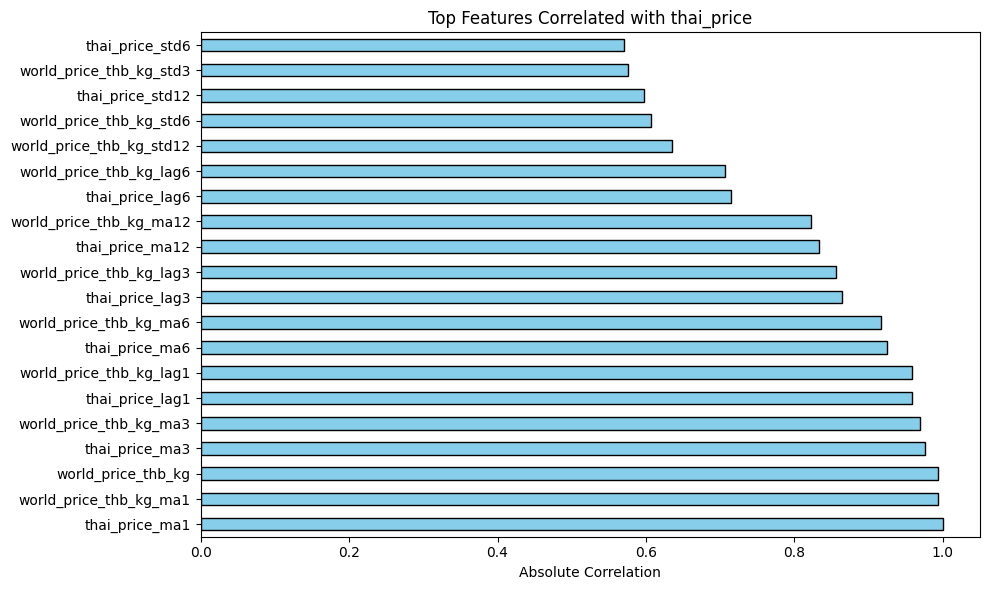


Selected 20 features


In [42]:
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

def select_features_by_correlation(df, target='thai_price', threshold=0.3, top_n=20):
    df = df.copy()
    
    # ตัดคอลัมน์ที่ไม่ใช่ numeric ออก (เช่น year_month)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_numeric = df[numeric_cols]
    
    if target not in df_numeric.columns:
        print(f"Error: '{target}' not found in numeric columns")
        print(f"Available numeric columns: {df_numeric.columns.tolist()}")
        return []
    
    # คำนวณ correlation กับ target
    correlations = df_numeric.corr()[target].abs().sort_values(ascending=False)
    
    # ตัด target ออก และเลือกที่มีค่ามากกว่า threshold
    correlations = correlations.drop(target)
    selected = correlations[correlations > threshold].head(top_n)
    
    print(f"Top {len(selected)} features with |correlation| > {threshold}:")
    print(selected)
    
    plt.figure(figsize=(10, 6))
    selected.head(20).plot(kind='barh', color='skyblue', edgecolor='black')
    plt.title(f'Top Features Correlated with {target}')
    plt.xlabel('Absolute Correlation')
    plt.tight_layout()
    plt.show()
    
    return selected.index.tolist()

selected_features = select_features_by_correlation(df_final, target='thai_price', threshold=0.3, top_n=20)
print(f"\nSelected {len(selected_features)} features")